In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

# Make Imbalaced Dataset

x_data: (150000, 10)
y_data: [134428, 15572]
x_train: (105000, 10)
y_train: [94100, 10900]
x_test: (45000, 10)
y_test: [40328, 4672]


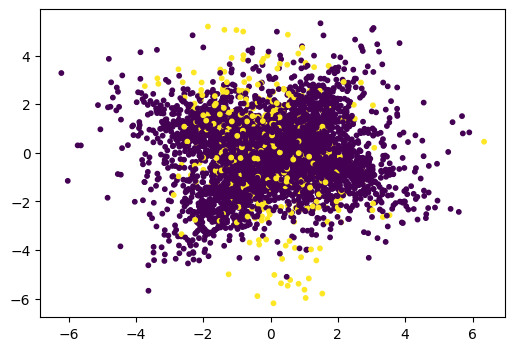

In [2]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

np.random.seed(0)
x_data, y_data = make_classification(
    n_samples=150000,
    n_features=8,
    n_informative=4,
    n_clusters_per_class=3,
    class_sep=0.6,
    weights=(0.9, 0.1),
    hypercube=False,
)
x_data = pd.DataFrame(x_data)
x_data.columns = [str(c) for c in x_data.columns]
x_data["rand1"] = np.random.rand(x_data.shape[0])
x_data["rand2"] = np.random.rand(x_data.shape[0])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, stratify=y_data)


print("x_data:", x_data.shape)
print("y_data:", pd.Series(y_data).value_counts().tolist())

print("x_train:", x_train.shape)
print("y_train:", pd.Series(y_train).value_counts().tolist())

print("x_test:", x_test.shape)
print("y_test:", pd.Series(y_test).value_counts().tolist())


pca = PCA(n_components=2)
pca_data = pca.fit_transform(x_data, y_data)
fig, plot = plt.subplots(1, figsize=(6, 4))
plot.scatter(pca_data[:5000, 0], pca_data[:5000, 1], c=y_data[:5000], marker="o", s=10)

# Model

## Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score

weight = y_test.sum() / len(y_test)
model = LogisticRegression(class_weight=(weight, 1 - weight))
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

y_true_count = ((y_test == y_pred) & (y_pred != 0)).sum()

print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print(f"{y_true_count} / {sum(y_test)} = {y_true_count / sum(y_test)}")

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     40328
           1       0.91      0.00      0.00      4672

    accuracy                           0.90     45000
   macro avg       0.90      0.50      0.47     45000
weighted avg       0.90      0.90      0.85     45000

Precision: 0.9090909090909091
Recall   : 0.0021404109589041095
10 / 4672 = 0.0021404109589041095


aa


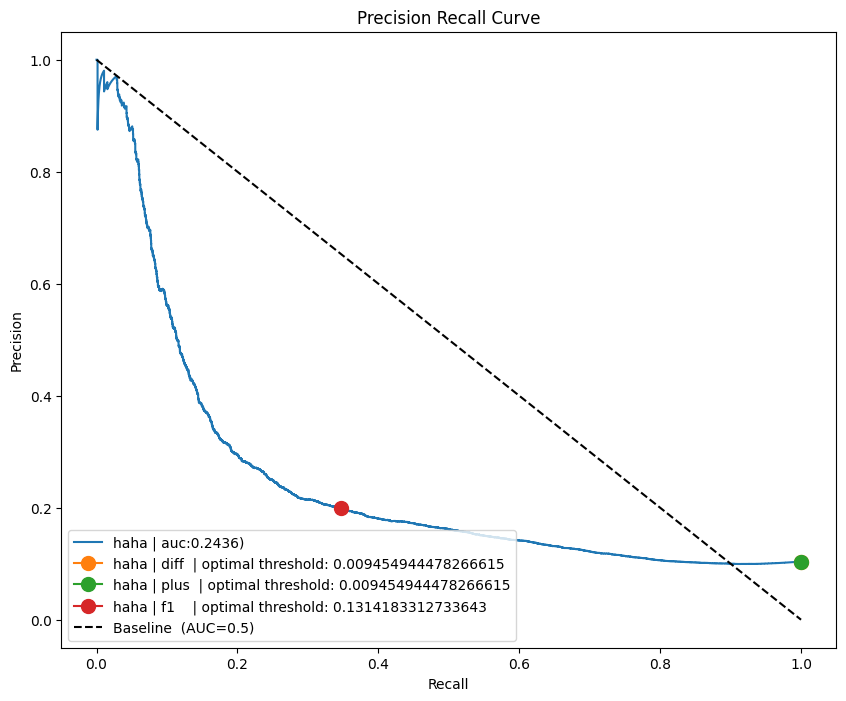

In [4]:
from sklearn.metrics import accuracy_score, auc, f1_score, precision_recall_curve


def calculate_prauc(y_true, y_prob, plot, label, method=[]):
    from collections.abc import Iterable

    def point_optimal_threshold(name):
        # Other Metrics at the max_threshold

        acc_ = accuracy_score(y_true, y_prob >= max_threshold)
        f1_ = f1_score(y_test, y_prob >= max_threshold)

        plot.plot(
            recall[max_idx],
            precision[max_idx],
            marker="o",
            markersize=10,
            label=f"{label} | {name:5} | optimal threshold: {max_threshold}",
        )

    if not isinstance(method, Iterable):
        method = [method]

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    auc_ = auc(recall, precision)
    plot.plot(recall, precision, label=f"{label} | auc:{auc_:.4f})")

    # Optimize the thesholds
    if "diff" in method:
        print("aa")
        max_idx = np.argmax(recall - precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("diff")

    if "plus" in method:
        max_idx = np.argmax(recall + precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("plus")

    if "f1" in method:
        fscores = 2 * (precision * recall) / (precision + recall)
        max_idx = np.argmax(fscores)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("f1")


y_prob = model.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "haha", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

y_true_count = ((y_test == y_pred) & (y_pred != 0)).sum()

print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print(f"{y_true_count} / {sum(y_test)} = {y_true_count / sum(y_test)}")

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     40328
           1       0.47      0.50      0.48      4672

    accuracy                           0.89     45000
   macro avg       0.71      0.72      0.71     45000
weighted avg       0.89      0.89      0.89     45000

Precision: 0.4715793747462444
Recall   : 0.4972174657534247
2323 / 4672 = 0.4972174657534247


aa


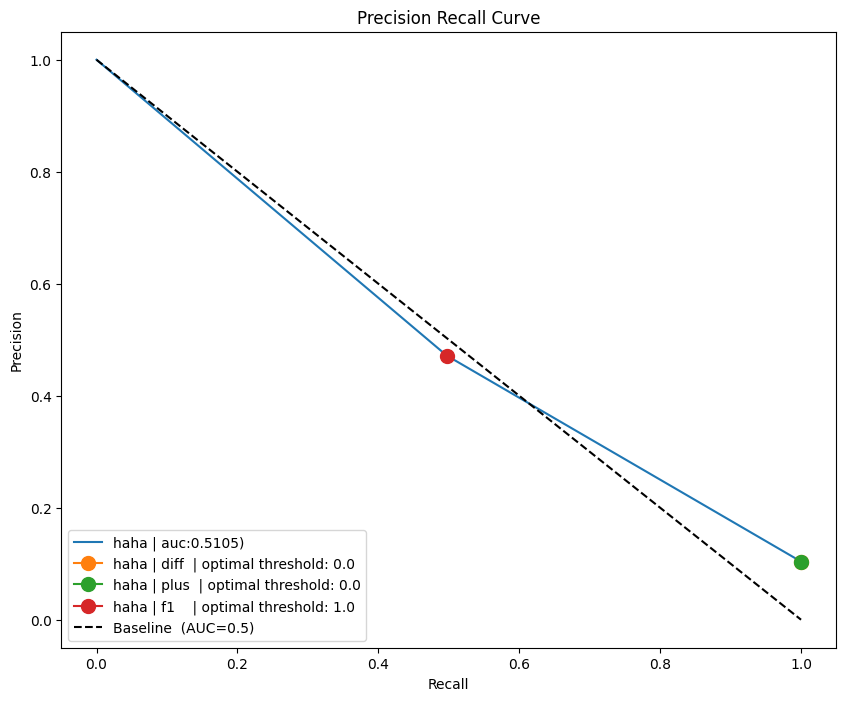

In [6]:
y_prob = model.predict_proba(x_test)[:, 1]

fig, plot = plt.subplots(1, figsize=(10, 8))
calculate_prauc(y_test, y_prob, plot, "haha", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## Class Weights

In [10]:
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset


class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_features, valid_features, train_labels, valid_labels = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

train_dataset = TabularDataset(train_features.values.astype('float32'), train_labels)
valid_dataset = TabularDataset(valid_features.values.astype('float32'), valid_labels)
test_dataset = TabularDataset(x_test.values.astype('float32'), y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

class_weights = torch.tensor((y_train == 0).sum() / y_train.sum(), dtype=torch.float)
print('class_weights:', class_weights)

# 모델 정의
class BinaryClassifier(pl.LightningModule):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.loss = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.batchnorm1(x)
        x = self.relu(self.layer3(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        loss = self.loss(logits, y.float().unsqueeze(1))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y.float().unsqueeze(1))
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
# 모델 훈련
model = BinaryClassifier(input_dim=x_train.shape[1])
trainer = pl.Trainer(max_epochs=10, gpus=1)
trainer.fit(model, train_dataloader, valid_dataloader)

/home/anderson/.pyenv/versions/3.7.16/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
------------------

class_weights: tensor(8.6330)


Sanity Checking: 0it [00:00, ?it/s]

/home/anderson/.pyenv/versions/3.7.16/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/anderson/.pyenv/versions/3.7.16/lib/python3.7/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
True